In [20]:
%%html
<style>
.int {
    padding:10px 0px 0px 30px;
}
dd {
    margin: 0px 0px 15px 0px;
}
dt {
   color:blue;
}
</style>

In [21]:
pwd

'C:\\Users\\Mark\\Dropbox\\GitHub\\PythonAutomatedTestRoutines\\Scripts'

# Overview
This notebook provides a quick-look analysis of the charging profile of Genesis charger's internal battery. This is not a general purpose notebook. It is intended to be customized for each battery to be tested.

# Background

## Definitions
<br/>
<dl>
    <dt>Capacity (<i>C</i>)</dt>
    <dd>The amount of charge available from a cell when discharged over a 20 hour period.</dd>
    <dt>Termination Current (<i>I<sub>Term</sub></i>)</dt>
    <dd>The current at which charging is terminated during the CV phase. It normally is set at a low value, like 0.05 C.</dd>
    <dt>Transistion Voltage (<i>V<sub>Transition</sub></i>)</dt>
    <dd>The cell voltage at which the charging algorithm switches from CC to CV. It typically is in the range of 4.1 V to 4.2 V.</dd>
    <dt>Normalized Current (<i>i<sub>N</sub></i>)</dt>
    <dd>The ratio of discharge current to battery capacity, which we can express as
         <div class="int">
        $
        \begin{align}
            i_N\triangleq\frac{i}{C}
         \end{align}
        $
        </div>
    </dd>
    <dt>Constant Current Phase (CC)</dt>
    <dd>For cell voltages < <i>V<sub>Transition</sub></i>, the battery is charged from a current source. The current source is usually set to a <i>i<sub>N</sub></i> = 0.1 C to 0.3 C.</dd>
    <dt>Constant Voltage Phase (CV)</dt>
    <dd>When the CC phase voltage reaches <i>V<sub>Transition</sub></i>, the cell voltage is then held at <i>V<sub>Transition</sub></i> and charging is continued until the charging current drops to <i>I<sub>Term</sub></i>. </dd>
</dl>

## Charging Algorithm

### General Information

* Genesis charger internal battery: <i>C</i> = 500 mAh.

### CC Phase

* Used for 3.0 V &leq; <i>V<sub>Cell</sub></i> &leq; 4.1 V.
* <i>I<sub>Charge</sub></i> = 247 mA, which is ~0.5 C.

### CV Phase

* <i>V<sub>Cell</sub></i> = 4.1 V.
* Continue charging while <i>I<sub>Charge</sub></i> &GreaterEqual; 24.7 mA, which is ~0.05 C.
* Charging is terminated when <i>I<sub>Charge</sub></i> = 24.7 mA.


## Analysis Setup

Except for graphics, I stuck with standard Python libraries. For graphics, I decided to plot using Seaborn, which is a nice upgrade to the Python standard Matplotlib. Note that Seaborn is based on Matplotlib.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator
import seaborn as sns

## Constant Current Phase Data
I wrote a Python script to charge Genesis internal battery, which is a 500 mAh battery. John Etherington defined the charge characteristics, so this routine simply evaluates the battery performance using this charge algorithm.

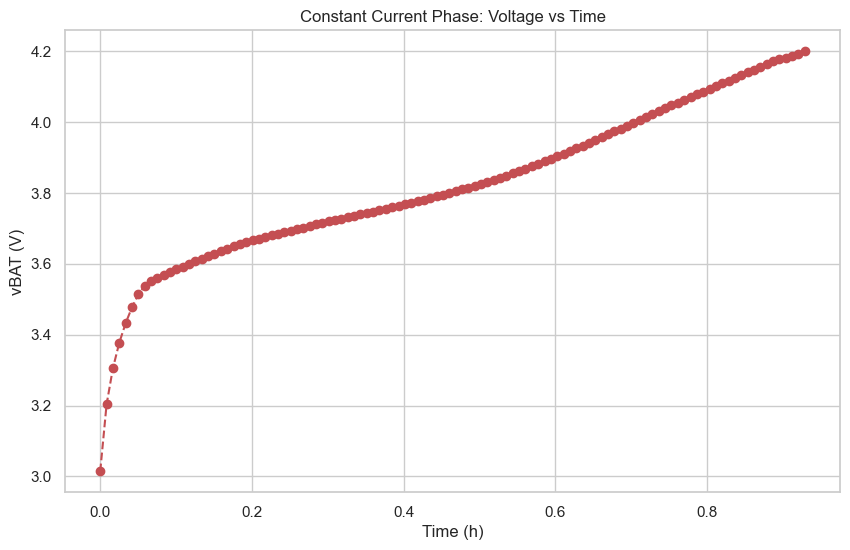

In [23]:
#  Import the CC Data

# Pull in the data file. Note that the file has a header, which the routine uses unmodified.
dfCC = pd.read_csv("../Data/CC_Charge_.csv")
dfCC['time'] = pd.to_datetime(dfCC['time'])
zeroTime = dfCC["time"].min()
dfCC.time = dfCC.time-zeroTime # Zero the time access to make more readable.
dfCC.time = dfCC.time/np.timedelta64(1, 'h')

# Graph the data
sns.set(font_scale=1.0, style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dfCC.time,dfCC.voltage, color='r',marker = 'o', linestyle ='--')
ax.set_xlabel('Time (h)')
ax.set_ylabel('vBAT (V)')
ax.set_title('Constant Current Phase: Voltage vs Time')
plt.show()


## Constant Voltage Phase Data

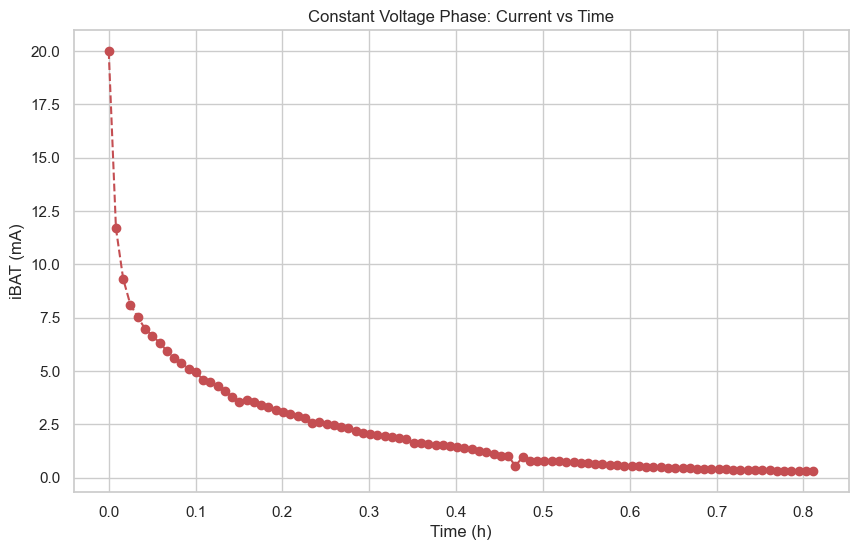

In [24]:
dfCV = pd.read_csv("../Data/CV_Bat_Current.csv", header=0)
dfCV.current = dfCV.current*1000
dfCV.time = pd.to_datetime(dfCV.time)
zeroTime = dfCV.time.min()
dfCV.time = dfCV.time-zeroTime
dfCV.time = dfCV.time/np.timedelta64(1, 'h')

sns.set(font_scale=1.0, style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dfCV.time,dfCV.current, color='r',marker = 'o', linestyle ='--')
ax.set_xlabel('Time (h)')
ax.set_ylabel('iBAT (mA)')
ax.set_title('Constant Voltage Phase: Current vs Time')
plt.show()

# Analysis

This section converts the charge characteristics to state-of-charge values.

## Total Charge Transferred During Charging

In [25]:
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
print("\n\n **************** CC Phase Tail ****************\n")
print(dfCC.tail())

# Charge transferred during the CC phase

interpolate_x = 4.2
y_interp = interp1d(dfCC['voltage'], dfCC['time']) # Create interpolation object
Q_CC = y_interp(interpolate_x)*10

print("\n\n **************** CC Termination Time ****************\n")
print("   CC Phase Termination Time: {:.2f} hours".format(y_interp(interpolate_x)))

# Charge transferred during the CV phase

interpolate_x = 0.3
y_interp = interp1d(dfCV.current, dfCV.time) # Create interpolation object
t_end = y_interp(interpolate_x)
f = InterpolatedUnivariateSpline(dfCV.time, dfCV.current, k=1)
Q_CV = f.integral(0,t_end)
Q_T = Q_CC+Q_CV
print("\n\n **************** CC Metrics ****************\n")
print("   Charge transferred during CC is {:.2f} mAh".format(Q_CC))
print("   Charge transferred during CV is {:.2f} mAh".format(Q_CV))
print("   Total charge transferred is {:.2f} mAh".format(Q_T))
print("   Percentage Transferred During CC is {:.2%}".format(Q_CC/(Q_CC+Q_CV)))



 **************** CC Phase Tail ****************

         time   voltage
107  0.895415  4.177427
108  0.903783  4.181380
109  0.912151  4.186709
110  0.920519  4.193205
111  0.928888  4.200174


 **************** CC Termination Time ****************

   CC Phase Termination Time: 0.93 hours


 **************** CC Metrics ****************

   Charge transferred during CC is 9.29 mAh
   Charge transferred during CV is 1.82 mAh
   Total charge transferred is 11.11 mAh
   Percentage Transferred During CC is 83.59%


## SOC Generation

Because the charge current is constant, integration vs time is simply multiplying the time by charge current. Note that SOC vs <i>V<sub>Cell</sub></i> only makes sense for <i>V<sub>Cell</sub></i> < 4.1 V. At 4.1 V, <i>V<sub>Cell</sub></i> is held constant and no longer conveys SOC information. Charging at this point is controlled by the HA's HPM10.

C:\Users\Mark\AppData\Local\Temp\ipykernel_10808\3195771619.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', color='grey', linewidth=0.35)
C:\Users\Mark\AppData\Local\Temp\ipykernel_10808\3195771619.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='black', linewidth=0.5)


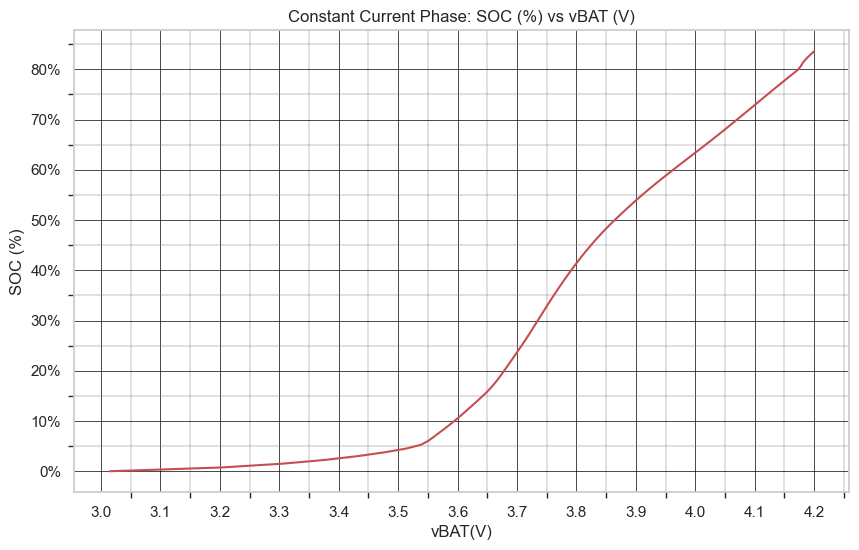

In [26]:
dfCC['SOC'] = dfCC['time']*10/Q_T
# Graph the data
import matplotlib.ticker as mtick
sns.set(font_scale=1.0, style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dfCC['voltage'], dfCC['SOC']*100, color='r',marker = None, linestyle ='-')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=True)
ax.grid(b=True, which='minor', color='grey', linewidth=0.35)
ax.grid(b=True, which='major', color='black', linewidth=0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('vBAT(V)')
ax.set_ylabel('SOC (%)')
ax.set_title('Constant Current Phase: SOC (%) vs vBAT (V)')
plt.show()

In [27]:
#val = float(input("discharge capacity?"))
#print(f'Estimated charging efficiency: {val/Q_T:0.2%}')
dfCC.head()

,time,voltage,SOC
0,0.000000,3.014371,0.000000
1,0.008371,3.202844,0.007535
2,0.016739,3.305355,0.015066
3,0.025104,3.377015,0.022595
4,0.033472,3.432222,0.030127


In [28]:
from scipy import interpolate
y = np.linspace(0, 80, num=81, endpoint=True)/100
iObject = interpolate.interp1d(dfCC.SOC,dfCC.voltage)
SOCnew = iObject(y)
lookup = pd.DataFrame({'SOC':y*100, 'voltage':SOCnew})
lookup.head()
lookup.tail()
lookup.to_csv('../Output/Charging_SOC_4_20.csv', index=False)